
---

## Objectives
1. Load raw IRDS skeleton data
2. Handle missing values and outliers
3. Normalize and standardize data
4. Create train/validation/test splits
5. Save preprocessed data for modeling


---


In [2]:
# Import libraries and load metadata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
from tqdm import tqdm
from scipy import interpolate
from scipy.stats import zscore
import pickle
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../../src')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# metadata from Data_Exploration.ipynb
metadata_path = Path("../../data/processed/metadata.csv")
df_metadata = pd.read_csv(metadata_path)

# Setup paths
DATA_PATH = Path("/path / to / data")
PROCESSED_PATH = Path("../../data/processed")
FIGURES_PATH = Path("../../results/figures/preprocessing")

# Create directories
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

print(f"✓ Loaded metadata with {len(df_metadata)} files")
print(f"✓ Data path: {DATA_PATH}")
print(f"✓ Processed data will be saved to: {PROCESSED_PATH}")

# Show class distribution
print("\nClass Distribution:")
print(df_metadata['position_binary'].value_counts())
print("\nGesture Distribution:")
print(df_metadata['gesture'].value_counts().sort_index())

✓ Loaded metadata with 2577 files
✓ Data path: /path / to / data
✓ Processed data will be saved to: ../../data/processed

Class Distribution:
Sitting     1311
Standing    1215
Unknown       51
Name: position_binary, dtype: int64

Gesture Distribution:
0    258
1    279
2    375
3    317
4    275
5    257
6    258
7    271
8    287
Name: gesture, dtype: int64


In [5]:
#  data loading and preprocessing functions
def load_skeleton_data(filepath):
    """skeleton data from a txt file"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            values = [float(x) for x in line.strip().split(',')]
            if len(values) == 75:  # 25 joints * 3 coordinates
                data.append(values)
    return np.array(data)

def normalize_sequence_length(sequence, target_length=100):
    # Check if sequence is already of target length
    current_length = len(sequence)
    if current_length == target_length:
        return sequence
    
    # Create time indices
    old_indices = np.linspace(0, 1, current_length)
    new_indices = np.linspace(0, 1, target_length)
    
    # Interpolate each feature
    normalized_sequence = np.zeros((target_length, sequence.shape[1]))
    for feature_idx in range(sequence.shape[1]):
        # Use cubic spline interpolation
        cs = interpolate.CubicSpline(old_indices, sequence[:, feature_idx])
        normalized_sequence[:, feature_idx] = cs(new_indices)
    
    return normalized_sequence

def normalize_coordinates(sequence):
    """
    Normalize coordinates relative to spine base (joint 0)
    """
    # Reshape to (frames, joints, 3)
    frames, features = sequence.shape
    sequence_3d = sequence.reshape(frames, 25, 3)
    
    # Get spine base coordinates
    spine_base = sequence_3d[:, 0, :]  # Shape: (frames, 3)
    
    # Subtract spine base from all joints
    normalized = sequence_3d - spine_base[:, np.newaxis, :]
    
    # Calculate body height (spine base to head)
    head_pos = normalized[:, 3, :]  # Head joint
    heights = np.linalg.norm(head_pos, axis=1)
    mean_height = np.mean(heights[heights > 0])
    
    # Normalize by height if valid
    if mean_height > 0:
        normalized = normalized / mean_height
    
    # Reshape back to original format
    return normalized.reshape(frames, -1)

def handle_missing_values(sequence):
    """
    Handle missing or invalid values in the sequence
    """
    # Replace inf and -inf with nan
    sequence = np.where(np.isinf(sequence), np.nan, sequence)
    
    # For each feature, interpolate missing values
    for feature_idx in range(sequence.shape[1]):
        feature = sequence[:, feature_idx]
        if np.any(np.isnan(feature)):
            # Find valid indices
            valid_idx = ~np.isnan(feature)
            if np.sum(valid_idx) > 1:
                # Interpolate
                x = np.arange(len(feature))
                sequence[:, feature_idx] = np.interp(x, x[valid_idx], feature[valid_idx])
            else:
                # fill with 0
                sequence[:, feature_idx] = 0
    
    return sequence



Analyzing sequence characteristics...


Analyzing sequences: 100%|██████████| 200/200 [00:00<00:00, 1337.73it/s]


=== Sequence Length Statistics ===
Min length: 21 frames
Max length: 899 frames
Mean length: 88.0 frames
Std length: 83.3 frames
Median length: 65.0 frames

=== Value Range Statistics ===
Global min value: -1.026
Global max value: 3.509
Files with NaN: 0
Files with Inf: 0


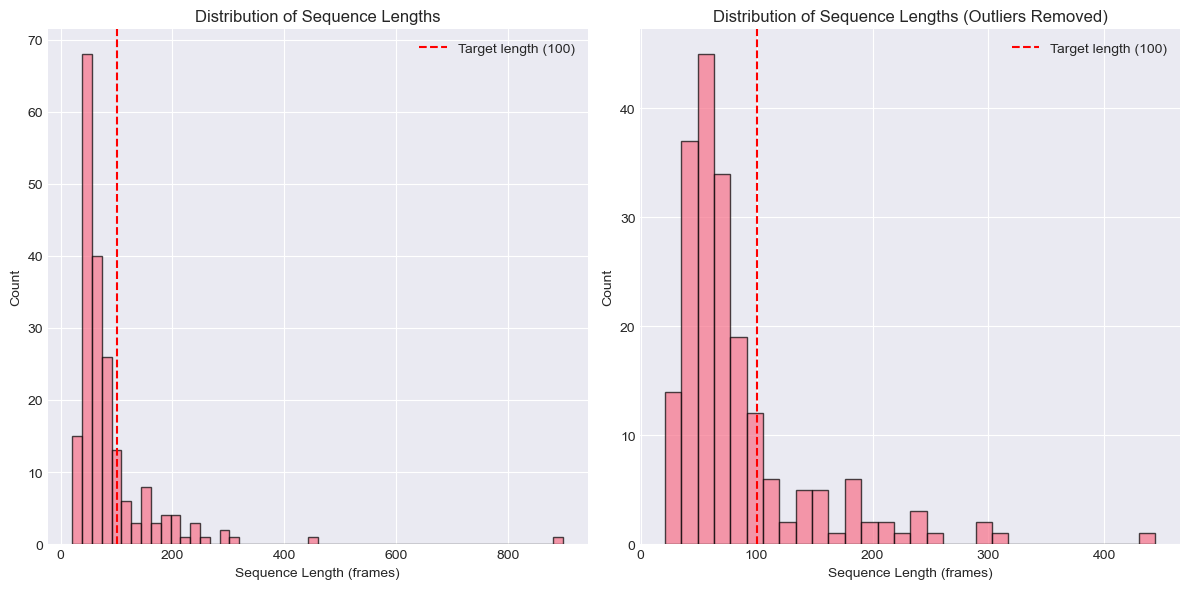


=== Sequence Length by Gesture ===
               mean         std  min  max
gesture                                  
0         73.956522   60.820510   32  309
1         68.863636   56.195488   21  233
2        111.129032   92.180526   22  444
3        148.923077  168.588000   44  899
4         82.375000   36.955604   39  172
5         74.130435   29.023978   41  179
6         80.260870   33.905239   44  204
7         67.900000   46.460963   32  245
8         52.812500   15.007637   29   79


In [ ]:
# Analyze sequence characteristics
print("Analyzing sequence characteristics...")

# Sample 200 random files for analysis
sample_size = min(200, len(df_metadata))
sample_metadata = df_metadata.sample(n=sample_size, random_state=42)

sequence_stats = []
for idx, row in tqdm(sample_metadata.iterrows(), total=sample_size, desc="Analyzing sequences"):
    filepath = DATA_PATH / row['filename']
    try:
        data = load_skeleton_data(filepath)
        
        # Calculate statistics
        stats = {
            'filename': row['filename'],
            'length': len(data),
            'gesture': row['gesture'],
            'position': row['position_binary'],
            'min_val': np.min(data),
            'max_val': np.max(data),
            'mean_val': np.mean(data),
            'std_val': np.std(data),
            'has_nan': np.any(np.isnan(data)),
            'has_inf': np.any(np.isinf(data))
        }
        sequence_stats.append(stats)
    except Exception as e:
        print(f"Error processing {filepath}: {e}")

df_stats = pd.DataFrame(sequence_stats)

# Display statistics
print("\n=== Sequence Length Statistics ===")
print(f"Min length: {df_stats['length'].min()} frames")
print(f"Max length: {df_stats['length'].max()} frames")
print(f"Mean length: {df_stats['length'].mean():.1f} frames")
print(f"Std length: {df_stats['length'].std():.1f} frames")
print(f"Median length: {df_stats['length'].median():.1f} frames")

print("\n=== Value Range Statistics ===")
print(f"Global min value: {df_stats['min_val'].min():.3f}")
print(f"Global max value: {df_stats['max_val'].max():.3f}")
print(f"Files with NaN: {df_stats['has_nan'].sum()}")
print(f"Files with Inf: {df_stats['has_inf'].sum()}")

# Visualize sequence length distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_stats['length'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(100, color='red', linestyle='--', label='Target length (100)')
plt.xlabel('Sequence Length (frames)')
plt.ylabel('Count')
plt.title('Distribution of Sequence Lengths')
plt.legend()

plt.subplot(1, 2, 2)
# Remove outliers for better visualization
lengths_no_outliers = df_stats['length'][df_stats['length'] < 500]
plt.hist(lengths_no_outliers, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(100, color='red', linestyle='--', label='Target length (100)')
plt.xlabel('Sequence Length (frames)')
plt.ylabel('Count')
plt.title('Distribution of Sequence Lengths (Outliers Removed)')
plt.legend()

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'sequence_length_distribution.png', dpi=150)
plt.show()

# Length by gesture
print("\n=== Sequence Length by Gesture ===")
length_by_gesture = df_stats.groupby('gesture')['length'].agg(['mean', 'std', 'min', 'max'])
print(length_by_gesture)

In [ ]:
# Preprocess all data
print("Starting data preprocessing...")
print("This will:")
print("1. Load all skeleton files")
print("2. Normalize sequence lengths to 100 frames")
print("3. Center coordinates on spine base")
print("4. Scale by body height")
print("5. Handle missing values")
print("6. Save processed data\n")


processed_data = []
failed_files = []

# Process all files
for idx, row in tqdm(df_metadata.iterrows(), total=len(df_metadata), desc="Processing files"):
    filepath = DATA_PATH / row['filename']
    
    try:
        # Load raw data
        raw_data = load_skeleton_data(filepath)
        
        # Skip if too few frames
        if len(raw_data) < 10:
            failed_files.append((row['filename'], 'Too few frames'))
            continue
        
        # Handle missing values
        cleaned_data = handle_missing_values(raw_data)
        
        # Normalize coordinates (center on spine base, scale by height)
        normalized_coords = normalize_coordinates(cleaned_data)
        
        # Normalize sequence length to 100 frames
        normalized_length = normalize_sequence_length(normalized_coords, target_length=100)
        
        # Store processed data with metadata
        processed_data.append({
            'data': normalized_length,
            'subject_id': row['subject_id'],
            'gesture': row['gesture'],
            'position': row['position_binary'],
            'correct_label': row['correct_label'],
            'filename': row['filename'],
            'original_length': len(raw_data)
        })
        
    except Exception as e:
        failed_files.append((row['filename'], str(e)))

print(f"\n✓ Successfully processed: {len(processed_data)} files")
print(f"✗ Failed to process: {len(failed_files)} files")

if failed_files:
    print("\nFailed files:")
    for filename, error in failed_files[:5]:
        print(f"  {filename}: {error}")
    if len(failed_files) > 5:
        print(f"  ... and {len(failed_files) - 5} more")

# Convert to numpy arrays for easier handling
X = np.array([item['data'] for item in processed_data])
y_position = np.array([item['position'] for item in processed_data])
y_gesture = np.array([item['gesture'] for item in processed_data])
metadata_processed = pd.DataFrame([{k: v for k, v in item.items() if k != 'data'} 
                                   for item in processed_data])

print(f"\n=== Processed Data Shape ===")
print(f"X shape: {X.shape}")
print(f"y_position shape: {y_position.shape}")
print(f"y_gesture shape: {y_gesture.shape}")
print(f"Metadata shape: {metadata_processed.shape}")

# Verify no NaN or Inf in processed data
print(f"\n=== Data Quality Check ===")
print(f"Contains NaN: {np.any(np.isnan(X))}")
print(f"Contains Inf: {np.any(np.isinf(X))}")
print(f"Data range: [{np.min(X):.3f}, {np.max(X):.3f}]")

Starting data preprocessing...
This will:
1. Load all skeleton files
2. Normalize sequence lengths to 100 frames
3. Center coordinates on spine base
4. Scale by body height
5. Handle missing values
6. Save processed data



Processing files: 100%|██████████| 2577/2577 [00:13<00:00, 196.92it/s]



✓ Successfully processed: 2577 files
✗ Failed to process: 0 files

=== Processed Data Shape ===
X shape: (2577, 100, 75)
y_position shape: (2577,)
y_gesture shape: (2577,)
Metadata shape: (2577, 6)

=== Data Quality Check ===
Contains NaN: False
Contains Inf: False
Data range: [-1.678, 2.036]


Creating train/test split for position classification...

=== Train/Test Split Statistics ===
Training set: 2061 samples
Test set: 516 samples
Train ratio: 79.98%
Test ratio: 20.02%

=== Position Distribution ===
Training set:
  Sitting: 1048 (50.8%)
  Standing: 972 (47.2%)
  Unknown: 41 (2.0%)

Test set:
  Sitting: 263 (51.0%)
  Standing: 243 (47.1%)
  Unknown: 10 (1.9%)

=== Subject Distribution ===
Unique subjects in train: 30
Unique subjects in test: 30
Overlapping subjects: 30


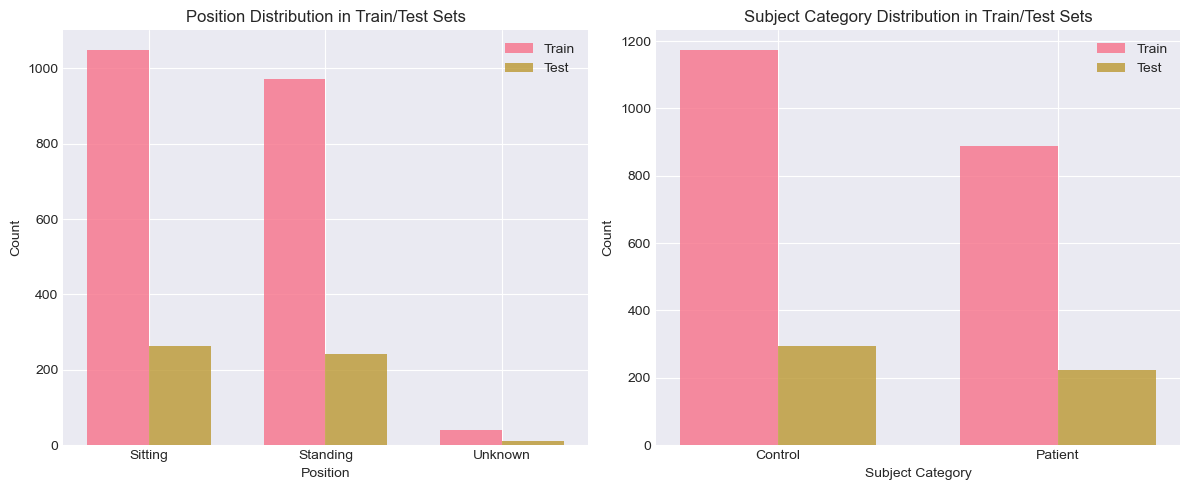

In [ ]:
# Create train/test split with stratification
from sklearn.model_selection import train_test_split

# For position classification (binary)
print("Creating train/test split for position classification...")

# Create stratification key combining position and subject category
metadata_processed['subject_category'] = metadata_processed['subject_id'].apply(
    lambda x: 'Patient' if 201 <= x <= 216 else 'Control'
)
stratify_key = metadata_processed['position'] + '_' + metadata_processed['subject_category']

# Split data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y_position, np.arange(len(X)), 
    test_size=0.2, 
    stratify=stratify_key,
    random_state=42
)

# Get corresponding metadata
train_metadata = metadata_processed.iloc[idx_train].copy()
test_metadata = metadata_processed.iloc[idx_test].copy()

print(f"\n=== Train/Test Split Statistics ===")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train ratio: {len(X_train)/len(X):.2%}")
print(f"Test ratio: {len(X_test)/len(X):.2%}")

# Check class distribution in train/test
print("\n=== Position Distribution ===")
print("Training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c} ({c/len(y_train):.1%})")

print("\nTest set:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c} ({c/len(y_test):.1%})")


print("Subject Distribution")
print(f"Unique subjects in train: {train_metadata['subject_id'].nunique()}")
print(f"Unique subjects in test: {test_metadata['subject_id'].nunique()}")
print(f"Overlapping subjects: {len(set(train_metadata['subject_id']) & set(test_metadata['subject_id']))}")

# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


ax1 = axes[0]
train_pos = pd.Series(y_train).value_counts()
test_pos = pd.Series(y_test).value_counts()
x = np.arange(len(train_pos))
width = 0.35
ax1.bar(x - width/2, train_pos.values, width, label='Train', alpha=0.8)
ax1.bar(x + width/2, test_pos.values, width, label='Test', alpha=0.8)
ax1.set_xlabel('Position')
ax1.set_ylabel('Count')
ax1.set_title('Position Distribution in Train/Test Sets')
ax1.set_xticks(x)
ax1.set_xticklabels(train_pos.index)
ax1.legend()


ax2 = axes[1]
train_cat = train_metadata['subject_category'].value_counts()
test_cat = test_metadata['subject_category'].value_counts()
x = np.arange(len(train_cat))
ax2.bar(x - width/2, train_cat.values, width, label='Train', alpha=0.8)
ax2.bar(x + width/2, test_cat.values, width, label='Test', alpha=0.8)
ax2.set_xlabel('Subject Category')
ax2.set_ylabel('Count')
ax2.set_title('Subject Category Distribution in Train/Test Sets')
ax2.set_xticks(x)
ax2.set_xticklabels(train_cat.index)
ax2.legend()

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'train_test_split_distribution.png', dpi=150)
plt.show()

In [ ]:
# Save preprocessed data
print("Saving preprocessed data...")

# Save as numpy arrays
np.save(PROCESSED_PATH / 'X_train.npy', X_train)
np.save(PROCESSED_PATH / 'X_test.npy', X_test)
np.save(PROCESSED_PATH / 'y_train_position.npy', y_train)
np.save(PROCESSED_PATH / 'y_test_position.npy', y_test)

# Save gesture labels
y_train_gesture = train_metadata['gesture'].values
y_test_gesture = test_metadata['gesture'].values
np.save(PROCESSED_PATH / 'y_train_gesture.npy', y_train_gesture)
np.save(PROCESSED_PATH / 'y_test_gesture.npy', y_test_gesture)

# Save metadata
train_metadata.to_csv(PROCESSED_PATH / 'train_metadata.csv', index=False)
test_metadata.to_csv(PROCESSED_PATH / 'test_metadata.csv', index=False)

# Save full processed data for later use
np.save(PROCESSED_PATH / 'X_full.npy', X)
np.save(PROCESSED_PATH / 'y_position_full.npy', y_position)
np.save(PROCESSED_PATH / 'y_gesture_full.npy', y_gesture)
metadata_processed.to_csv(PROCESSED_PATH / 'metadata_processed.csv', index=False)

# Create a summary file
summary = {
    'total_samples': len(X),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'features_per_sample': X.shape[1] * X.shape[2],
    'sequence_length': X.shape[1],
    'features_per_frame': X.shape[2],
    'num_positions': len(np.unique(y_position)),
    'num_gestures': len(np.unique(y_gesture)),
    'position_classes': list(np.unique(y_position)),
    'gesture_classes': list(np.unique(y_gesture))
}

with open(PROCESSED_PATH / 'preprocessing_summary.txt', 'w') as f:
    f.write("PREPROCESSING SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")

print("\n✓ Data saved successfully!")
print(f"Location: {PROCESSED_PATH}")
print("\nSaved files:")
for file in sorted(PROCESSED_PATH.glob('*')):
    if file.is_file():
        size_mb = file.stat().st_size / 1024 / 1024
        print(f"  {file.name}: {size_mb:.2f} MB")

print("\n" + "="*50)
print("PREPROCESSING COMPLETE!")
print("="*50)
print(f"Total samples: {len(X)}")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features per sample: {X.shape[1] * X.shape[2]}")
print(f"Ready for feature engineering!")

Saving preprocessed data...

✓ Data saved successfully!
Location: ../../data/processed

Saved files:
  X_full.npy: 147.46 MB
  X_test.npy: 29.53 MB
  X_test_biomechanical.npy: 0.16 MB
  X_test_combined.npy: 2.52 MB
  X_test_pca.npy: 0.45 MB
  X_test_statistical.npy: 2.36 MB
  X_train.npy: 117.93 MB
  X_train_biomechanical.npy: 0.64 MB
  X_train_combined.npy: 10.08 MB
  X_train_pca.npy: 1.79 MB
  X_train_statistical.npy: 9.43 MB
  feature_engineering_summary.txt: 0.00 MB
  metadata.csv: 0.15 MB
  metadata_processed.csv: 0.13 MB
  pca_model.pkl: 3.16 MB
  preprocessing_summary.txt: 0.00 MB
  scaler.pkl: 0.02 MB
  test_metadata.csv: 0.03 MB
  train_metadata.csv: 0.10 MB
  y_gesture_full.npy: 0.02 MB
  y_position_full.npy: 0.08 MB
  y_test_gesture.npy: 0.00 MB
  y_test_position.npy: 0.02 MB
  y_train_gesture.npy: 0.02 MB
  y_train_position.npy: 0.06 MB

PREPROCESSING COMPLETE!
Total samples: 2577
Train samples: 2061
Test samples: 516
Features per sample: 7500
Ready for feature engineering!